### Three-body problem 

In contrast to the 2-body problem, the **3-body problem doesn't admit a general closed-form solution**. Thus, numerical methods are generally required. 

We'll start first with a restricted case of the three body problem, in which we consider a body (let's say a rocket) with a "small" mass, compared to the mass of the other two bodies (say Earth and Moon). Under this condition, the rocket does **NOT perturb** the motion of the earth and the moon.

To solve this problem numerically we'll assume the following:

* **Three bodies:**  Earth ($M_E$), Moon ($M_M$) and Rocket ($m$), with **$m$ << $M_E$, $M_M$**, so the rocket does not influence their motion.


* The **motion** of the three bodies always **lies** in a **plane**, so we can assume a 2-dimensional problem.


* The rocket takes off from the surface of the Earth, with initial velocity v0 and some angle of inclination $\theta$.


* We take the **Earth** as the **frame of reference**, so it doesn't move.


* We approximate the orbit of the **Moon** (ellipse) to a **circular orbit**. We take a constant angular momentum $\omega$.  


* We work with **polar coordinates**. 


Let's derive the equations of motion governing the motion of the rocket.

The kinetic enrgy of the rocket is:

$$ T=\frac{1}{2} m\left(\dot{x}^{2}+\dot{y}^{2}\right)=\frac{1}{2} m\left(\dot{r}^{2}+r^{2} \dot{\phi}^{2}\right) \tag{1} $$

where $r(t)$ is the position of the rocket with respect to the Earth and $\phi$ is its angular position. We've also used the **dot notation**, where $\dot{r} \equiv \frac{dr}{dt}$. The potential energy, on the other hand, is

$$  V=-G \frac{m M_{E}}{r}-G \frac{m M_{M}}{r_{M}(r, \phi, t)}  \tag{2}  $$

being $r_{M}(r, \phi, t)$ the distance between the rocket and the moon. Using some trigonometry and the law of cosines, one ca prove that $r_{M}(r, \phi, t) = \left[r(t)^{2}+d_{E M}^{2}-2 r(t) d_{E M} \cos (\phi-\omega t)\right]^{1 / 2} $ with $d_{E M}$ the distance between the Earth and the Moon (a constant). This leads to the following Hamiltonian:

$$ H = \frac{p_{r}^{2}}{2 m}+\frac{p_{\phi}^{2}}{2 m r^{2}}-G \frac{m M_{E}}{r}-G \frac{m M_{M}}{r_{M}(r, \phi, t)}  \tag{3} $$

where we've introduced $p_r = m\dot{r}$, $p_{\phi} = mr^2\dot{\phi}$  the generalized momentums associated with the coordinates $r$ and $\phi$. Thus, the equation of motion are (Hamilton's equations):

$$
\begin{aligned}
\dot{r} &=\frac{\partial H}{\partial p_{r}}=\frac{p_{r}}{m} \\
\dot{\phi} &=\frac{\partial H}{\partial p_{\phi}}=\frac{p_{\phi}}{m r^{2}}, \\
\dot{p}_{r} &=-\frac{\partial H}{\partial r}=\frac{p_{\phi}^{2}}{m r^{3}}-G \frac{m M_{E}}{r^{2}}-G \frac{m M_{M}}{r_{M}^{3}(r, \phi, t)}\left[r-d_{E M} \cos (\phi-\omega t)\right] \\
\dot{p}_{\phi} &=-\frac{\partial H}{\partial \phi}=-G \frac{m M_{M}}{r_{E}^{3}(r, \phi, t)} r d_{E M} \sin (\phi-\omega t)
\end{aligned}  \tag{4}$$


Because the magnitude order of $r$, $\phi$, $p_r$, $p_{\phi}$ are so different, this can lead to "intrinsic" numerical error. So, we'll **redefine the variables** in order to make them similar (order of magnitude). We consider the following new variables: 
$\tilde{r}=r / d_{E M}$,  $\phi$,  $\tilde{p}_{r}=p_{r} / m d_{E M}$ and $\tilde{p}_{\phi}=p_{\phi} / m d_{E M}^{2}$ which leads to the following equations of motion:

$$
\begin{aligned}
&\dot{\tilde{r}}=\tilde{p}_{r} \\
&\dot{\phi}=\frac{\tilde{p}_{\phi}}{\tilde{r}^{2}} \\
&\dot{\tilde{p}}_{r} =\frac{\tilde{p}_{\phi}^{2}}{\tilde{r}^{3}}-\Delta\left\{\frac{1}{\tilde{r}^{2}}+\frac{\mu}{\tilde{r}^{\prime 3}}[\tilde{r}-\cos (\phi-\omega t)]\right\} \\ 
&\dot{\tilde{p}}_{\phi} =-\frac{\Delta \mu \tilde{r}}{\tilde{r}^{\prime 3}} \sin (\phi-\omega t)
\end{aligned}
\tag{5}
$$

where $\Delta \equiv G M_{E} / d_{E M}^{3}, \mu \equiv M_{M} / M_{E}$ and $\tilde{r}^{\prime} \equiv\left[1+\tilde{r}^{2}-2 \tilde{r} \cos (\phi-\omega t)\right]^{1 / 2}$

To solve this set of first order differential equations we could use the built-in package solver of "Scipy" for example (odeint or solve_ivp) but we'd like to keep track of the values of the magnitudes during the algorithm. For example, if it turns out that at any time the radial position of the rocket, r, is less than the radius of the Earth, this means that the rocket has crashed into the surface and we have to stop the simulation. Hence, we will use RK4 to solve the equations of motion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from math import cos, sqrt, sin, pi
from numba import jit
from matplotlib.animation import PillowWriter
import matplotlib

Initial conditions:

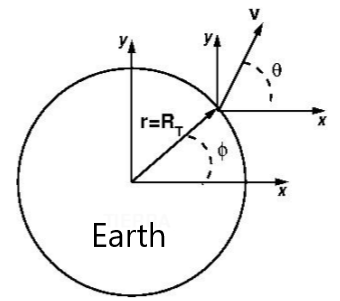

In [2]:
def initial_cond():
    
    '''
    r0 : the radial position of the rocket at time t=0
    phi : the angular position of the rocket in the surface of the Earth
    v0 : initial veolcity of the rocket
    theta : angular direction of the initial velocity
    '''
    #Distance Earth-Moon and Earth radius
    d_em = float(3.844e8)
    R_e = float(6.37816e6)
    G = float(6.67e-11)
    M_e = float(5.9736e24)
    
    #We suppose the launching at the surface
    r0 = 1.001*R_e
    phi = 37*np.pi/180
    theta = 35*np.pi/180
    v = 11210.0 #Escape velocity

    v0 = 0.99*v/d_em

    #(y1, y2, y3, y4) = (r, phi, p_r,  p_phi)
    y1 = r0/d_em
    y2 = phi
    
    #With some trigonometry, one can prove that p_r and p_phi are
    y3 = v0*cos(theta-y2)
    y4 = y1*v0*sin(theta-y2)
       
    return y1, y2, y3, y4

In [3]:
#Equations of motion

@jit
def dydt(t, y1, y2, y3, y4, i):

    #Constants
    G = float(6.67e-11)
    M_e = float(5.9736e24)
    M_m = float(0.07349e24)
    d_em = float(3.844e8)
    w = float(2.6617e-6)    #Angular veolcity of Moon

    delta = G*M_e/(d_em**3)
    mu = M_m/M_e

    if i ==0:
        return y3

    elif i == 1:
        return y4/(y1**2)

    elif i == 2:
        r_ = sqrt( 1 + y1**2 - 2*y1*cos(y2 - w*t) ) 
        return (y4**2)/(y1**3) - delta*( 1/(y1**2) + (mu/(r_**3))*( y1 - cos(y2 - w*t) ))

    else:
        r_ = sqrt( 1 + y1**2 - 2*y1*cos(y2 - w*t) ) 
        return -(delta*mu*y1/(r_**3))*sin(y2 - w*t)

In [4]:
@jit
def rungeKutta(t, y1, y2, y3, y4, h, steps):
    
    for j in range(steps):
        
        k1, k2, k3, k4 = np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4)
        
        for i in range(4):
            
            k1[i] = h*dydt(t[j], y1[j] , y2[j], y3[j], y4[j], i)
            
        for i in range(4):
                      
            k2[i] = h*dydt(t[j] + 0.5*h, y1[j] + 0.5*k1[0], y2[j] + 0.5*k1[1], y3[j] + 0.5*k1[2], y4[j] + 0.5*k1[3], i)
        
        for i in range(4):
            
            k3[i] = h*dydt(t[j] + 0.5*h, y1[j] + 0.5*k2[0], y2[j] + 0.5*k2[1], y3[j] + 0.5*k2[2], y4[j] + 0.5*k2[3], i)
        
        for i in range(4):
            
            k4[i] = h*dydt(t[j] + h, y1[j] + k2[0], y2[j] + k2[1], y3[j] + k2[2], y4[j] + k2[3], i)
            

        # Update next value of y and t
        y1[j+1] = y1[j] + (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])/6
        y2[j+1] = y2[j] + (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])/6
        y3[j+1] = y3[j] + (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])/6
        y4[j+1] = y4[j] + (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])/6

        t[j+1] = t[j]+h
        
        #Checking if the spacefraft has crashed into the Moon or Earth
        w = float(2.6617e-6)
        R_e = float(6.37816e6)
        R_m = float(1.734e6)
        d_em = float(3.844e8)
        
        x_moon = cos(w*t[j+1])
        y_moon = sin(w*t[j+1])
        
        x_rocket = y1[j+1]*cos(y2[j+1])
        y_rocket = y1[j+1]*sin(y2[j+1])
        
        # Basically, we're checking if the rocket x-y position satisfy the equation
        # of a cirlce, of radius r_e or r_m 
        if ((x_rocket - x_moon)**2 + (y_rocket - y_moon)**2) < (R_m/d_em)**2:
            
            print('Spacecraft has crashed into the Moon!')
            
            #Just to get rid of the 0-values
            for k in range(j, steps):
                y1[k+1] = y1[k]
                y2[k+1] = y2[k]
                y3[k+1] = y3[k]
                y4[k+1] = y4[k]
                t[k+1] = t[k]
                
            return t, y1, y2, y3, y4

        if ((x_rocket - 0)**2 + (y_rocket - 0)**2) < (R_e/d_em)**2:
            
            print('Spacecraft has crashed into the Earth!')
            
            for k in range(j, steps):
                y1[k+1] = y1[k]
                y2[k+1] = y2[k]
                y3[k+1] = y3[k]
                y4[k+1] = y4[k]
                t[k+1] = t[k]
                
            return t, y1, y2, y3, y4
        
    return t, y1, y2, y3, y4

In [5]:
# Initializing the variables
steps = 50000
h = 100


y1, y2, y3, y4 = np.zeros(steps+1), np.zeros(steps+1), np.zeros(steps+1), np.zeros(steps+1)
t = np.zeros(steps+1)

y1[0], y2[0], y3[0], y4[0] = initial_cond()

In [6]:
#Solving the equations

t, y1, y2, y3, y4 = rungeKutta(t, y1, y2, y3, y4, h, steps)

### Plotting the results

In [7]:
x_rocket = y1*np.cos(y2)
y_rocket = y1*np.sin(y2)

w = 2.6617*10**-6

x_moon = np.cos(t*w)
y_moon = np.sin(t*w)

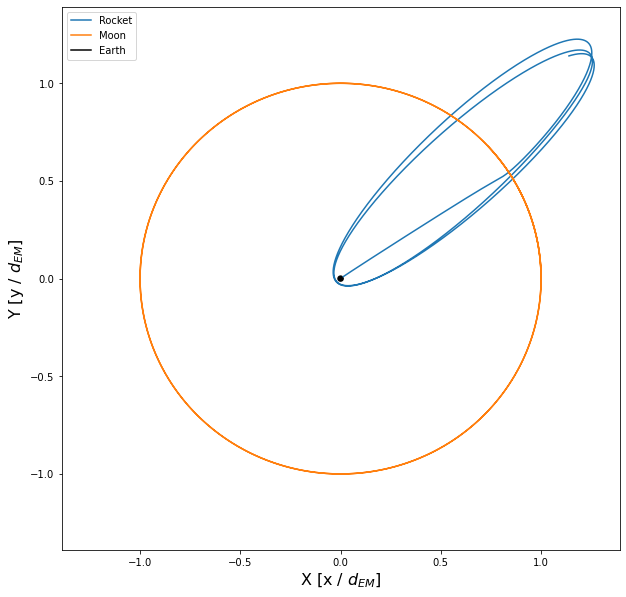

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

#Rocket
axes.plot(x_rocket, y_rocket, label = 'Rocket')

#Moon         
axes.plot(x_moon, y_moon, label = 'Moon')

#Earth
axes.plot(0,0, markersize = 0, c = 'black', label = 'Earth')  #Just to add the label
earth = [plt.Circle((0, 0), radius = 0.0166, linewidth=0)]
c_earth = matplotlib.collections.PatchCollection(earth, facecolors='Black')
axes.add_collection(c_earth)

if x_rocket.max() > y_rocket.max():
    
    axes.set_xlim(-1.1*x_rocket.max(),1.1*x_rocket.max())
    axes.set_ylim(-1.1*x_rocket.max(), 1.1*x_rocket.max())
    
else:
    axes.set_xlim(-1.1*y_rocket.max(),1.1*y_rocket.max())
    axes.set_ylim(-1.1*y_rocket.max(), 1.1*y_rocket.max())
    
          
axes.set_xlabel('X [x / $d_{EM}$]', fontsize = 16)
axes.set_ylabel('Y [y / $d_{EM}$]', fontsize = 16)
axes.legend()


plt.show()

In [9]:
# Animation
def make_animation():
    fig, axes = plt.subplots(1, 1, figsize=(10,10))
    speed = 70

    def animate(i):
        
        d_tl = float(3.844e8)
        R_t = float(6.37816e6)
        R_l = float(1.734e6)

        ax = axes
        ax.clear()
        
        #To jump some frames and make the animation faster
        speed = 70
        
        #To make Earth, moon and rocket bigger
        scale_factor = 5

        x_rock, y_rock = x_rocket[speed*i],y_rocket[speed*i]
        x_m, y_m = x_moon[speed*i], y_moon[speed*i]
        x_earth, y_earth = 0, 0
        
        
        #Plotting Earth, Moon and Rocket as a circles
        moon = [plt.Circle((x_m, y_m), radius=scale_factor*R_l/d_tl, linewidth=0)]
        earth = [plt.Circle((x_earth, y_earth), radius=scale_factor*R_t/d_tl, linewidth=0)]
        rocket = [plt.Circle((x_rock, y_rock), radius=scale_factor*0.5*R_l/d_tl, linewidth=0)]

        c_moon = matplotlib.collections.PatchCollection(moon, facecolors='grey')
        c_earth = matplotlib.collections.PatchCollection(earth, facecolors='blue')
        c_rocket = matplotlib.collections.PatchCollection(rocket, facecolors='black')

        ax.add_collection(c_rocket)
        ax.add_collection(c_moon)
        ax.add_collection(c_earth)
        
        #Axes limits
        if x_rocket.max() > y_rocket.max():
    
            ax.set_xlim(-1.1*x_rocket.max(),1.1*x_rocket.max())
            ax.set_ylim(-1.1*x_rocket.max(), 1.1*x_rocket.max())

        else:
            ax.set_xlim(-1.1*y_rocket.max(),1.1*y_rocket.max())
            ax.set_ylim(-1.1*y_rocket.max(), 1.1*y_rocket.max())
            
        axes.set_xlim(-1.3, 1.3)
        axes.set_ylim(-1.3, 1.3)

        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)

        ax.set_xlabel('X [1/$d_{EM}$]')
        ax.set_ylabel('Y [1/$d_{EM}$]')
        ax.set_title("Time = {} days".format(round(speed*i*h/(60*60*24), 2)))


        fig.tight_layout()

    ani = animation.FuncAnimation(fig, animate, frames=int(steps/speed), interval=1)
    ani.save(r'three_body.gif')


MovieWriter ffmpeg unavailable; using Pillow instead.


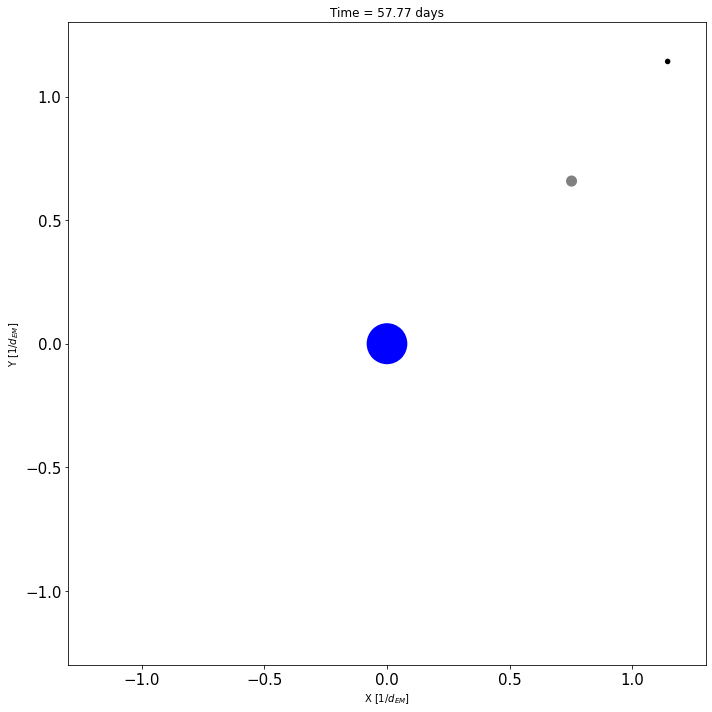

In [10]:
make_animation()